# **Breaking Bottlenecks: Delivery Gameplan for Olist**
Courtesy of Team Alpha (DTIDSOL-02):
- Josephine Rahma Gunawan
- Rio Pramana
- Risma Widiya Puspadevi

### **Contents:**

1. Understanding the Business Problem
2. Data Cleaning & Familiarisation
3. Exploratory Data Analysis (EDA)
4. Insights & Key Findings
5. Summary of Findings
6. Conclusion & Business Implications
7. Limitations & Considerations
8. Actionable Recommendations

# **Understanding the Business Problems**

### Background and Business Objective

E-commerce has rapidly transformed how people shop, especially in Brazil, where convenience, price, and speed play crucial roles in consumer decisions. According to a report by **NielsenIQ**, Brazilian shoppers cited the following top reasons for choosing online platforms:

- **77%** – Best price  
- **57%** – Delivery time  
- **54%** – Product variety  
- **39%** – Special promotions (e.g., free shipping, discounts, loyalty programmes)

The fact that *delivery time* ranks second highlights just how important a fast, reliable shipping experience is to customers (nearly as important as pricing itself).

For **Olist**, a major e-commerce platform that connects small and medium-sized retailers to marketplaces in Brazil, this puts increasing pressure on fulfilment operations. Delivery performance isn’t just a logistical concern. It's a business-critical metric that can influence customer satisfaction, retention, and ultimately, sales performance.

### Why Focus on On-Time Delivery (OTD)?

To evaluate delivery performance, we focus on the industry-standard metric: **On-Time Delivery (OTD)**. OTD measures the percentage of orders delivered within the promised timeframe and is calculated as:

> **OTD (%) = (Number of on-time deliveries / Total deliveries in the period) × 100**

As highlighted in a blog by **[Delage](https://delage.com.br/blog/otd-on-time-delivery-saiba-tudo-sobre-um-dos-principais-indicadores-para-o-e-commerce/)**, OTD has become one of the most relevant indicators in e-commerce logistics today. It reflects the efficiency of the entire order fulfilment process from the time an order is picked and packed to when it’s handed off by the courier.

Importantly, a survey by **Reclame Aqui** showed that **18.6% of consumers abandon their online shopping carts** if the estimated delivery time doesn’t meet their expectations. While this figure may seem modest at first glance, nearly **1 in 5 lost sales** can severely impact an e-commerce company’s bottom line, especially at scale.

Furthermore, an article by **[Gazeta do Povo](https://www.gazetadopovo.com.br/economia/e-commerce-brasileiro-busca-alternativas-a-correiodependencia-an1xq7tj25k1nnxytsml2tb4q/)** noted that logistics companies proudly advertise achieving **95% OTD** as a sign of operational excellence. While not a formal industry standard, this 95% mark is widely regarded as a benchmark for competitive performance in Brazil’s e-commerce landscape.

### Project Objective

Given the critical role that delivery time plays in consumer satisfaction and conversion rates, the objective of this project is to:

> **Improve Olist's delivery performance by increasing its On-Time Delivery (OTD) rate, aiming for a minimum benchmark of 95%.**

In addition to descriptive and diagnostic analysis, this project also leverages **machine learning to predict whether a delivery will be late or on time** based on various features available at the time of order. The goal is to take **preventive action** on high-risk deliveries such as prioritising processing or flagging for courier follow-up before issues occur.

Through data-driven insights and predictive modelling, this project aims to help Olist optimise its logistics performance, meet customer expectations, and improve overall business outcomes.

## Import Libraries & Datasets

In [ ]:
# Data Handling & Manipulation
import pandas as pd                                         # for dataframes, CSV/Excel reading, tabular data manipulation
import numpy as np                                          # for numerical operations and array handling

# Data Visualisation (Static)
import matplotlib.pyplot as plt                             # for creating static plots
from matplotlib.ticker import FuncFormatter                 # for customising tick labels (e.g., currency, %)
import seaborn as sns                                       # for statistical visualisation (heatmaps, distplots, etc.)

# Data Visualisation (Interactive)
import plotly.express as px                                 # for quick and interactive visualisation
import plotly.graph_objects as go                           # for custom interactive plots
from plotly.subplots import make_subplots                   # for interactive subplots

# Statistical Testing & Inference
from statsmodels.stats.proportion import proportions_ztest  # for comparing proportions (e.g., late vs. on-time)
from scipy.stats import (
    normaltest,                                             # for checking normality
    chi2_contingency,                                       # for categorical association
    mannwhitneyu,                                           # for non-parametric testing
    ttest_ind,                                              # for independent sample t-test
    f_oneway,                                               # for one-way ANOVA
    kruskal,                                                # for Kruskal-Wallis test
    kstest                                                  # for Kolmogorov-Smirnov test
)
import statsmodels.api as sm                                # for advanced statistical modelling and diagnostics
import statsmodels.formula.api as smf                       # for formula-based statistical models
from statsmodels.stats.multicomp import pairwise_tukeyhsd   # for post-hoc tests after ANOVA

# Data Quality & Missing Value Visualisation
import missingno as msno                                    # for visualising missing data patterns

# System & Settings
import os                                                   # for file handling and directory operations
import warnings                                             # to suppress or manage warning messages
warnings.filterwarnings("ignore", category=FutureWarning)
pd.set_option('display.max_colwidth', None)                 # display full content in cells (useful for text data)

In [ ]:
# List of date columns for each Olist dataset
# This dictionary maps each dataset filename to a list of columns that should be parsed as dates.
date_cols = {
    'olist_orders_dataset.csv': [
        'order_purchase_timestamp',
        'order_approved_at',
        'order_delivered_carrier_date',
        'order_delivered_customer_date',
        'order_estimated_delivery_date',
    ],
    'olist_order_items_dataset.csv': [
        'shipping_limit_date',
    ],
    'olist_order_reviews_dataset.csv': [
        'review_creation_date',
        'review_answer_timestamp',
    ],
    # The following datasets have NO date columns:
    # 'olist_customers_dataset.csv'
    # 'olist_geolocation_dataset.csv'
    # 'olist_order_payments_dataset.csv'
    # 'olist_products_dataset.csv'
    # 'olist_sellers_dataset.csv'
    # 'product_category_name_translation.csv'
    'master_olist_dataset.csv': [
        'order_purchase_timestamp',
        'order_approved_at',
        'order_delivered_carrier_date',
        'order_delivered_customer_date',
        'order_estimated_delivery_date',
        'shipping_limit_date',
        'review_creation_date',
        'review_answer_timestamp',
    ]
}

def read_olist_csv(path):
    """
    Reads an Olist CSV and parses dates for the correct columns.
    Args:
        path (str): Path to the CSV file.
    Returns:
        pd.DataFrame: Loaded dataframe with date columns parsed as datetime.
    """
    # Extract just the filename, e.g., 'olist_orders_dataset.csv'
    filename = os.path.basename(path)
    # Get the correct date columns for this file, or an empty list
    parse_dates = date_cols.get(filename, [])
    # Read the CSV, parsing the specified date columns (if any)
    return pd.read_csv(path, parse_dates=parse_dates)

Load original (raw) datasets:

In [704]:
original_df_orders           = read_olist_csv('../data/original_data/olist_orders_dataset.csv')
original_df_customers        = read_olist_csv('../data/original_data/olist_customers_dataset.csv')
original_df_order_items      = read_olist_csv('../data/original_data/olist_order_items_dataset.csv')
original_df_order_payments   = read_olist_csv('../data/original_data/olist_order_payments_dataset.csv')
original_df_reviews          = read_olist_csv('../data/original_data/olist_order_reviews_dataset.csv')
original_df_products         = read_olist_csv('../data/original_data/olist_products_dataset.csv')
original_df_prod_cat_tr      = read_olist_csv('../data/original_data/product_category_name_translation.csv')
original_df_sellers          = read_olist_csv('../data/original_data/olist_sellers_dataset.csv')
original_df_geolocation      = read_olist_csv('../data/original_data/olist_geolocation_dataset.csv')

Load cleaned datasets

In [717]:
cleaned_delivered_df_orders           = read_olist_csv('../data/cleaned_data/olist_orders_dataset.csv')
cleaned_df_customers        = read_olist_csv('../data/cleaned_data/olist_customers_dataset.csv')
cleaned_delivered_df_order_items      = read_olist_csv('../data/cleaned_data/olist_order_items_dataset.csv')
cleaned_delivered_df_order_payments   = read_olist_csv('../data/cleaned_data/olist_order_payments_dataset.csv')
cleaned_delivered_df_reviews          = read_olist_csv('../data/cleaned_data/olist_order_reviews_dataset.csv')
cleaned_df_products         = read_olist_csv('../data/cleaned_data/olist_products_dataset.csv')
cleaned_df_prod_cat_tr      = read_olist_csv('../data/cleaned_data/product_category_name_translation.csv')
cleaned_df_sellers          = read_olist_csv('../data/cleaned_data/olist_sellers_dataset.csv')
cleaned_df_geolocation      = read_olist_csv('../data/cleaned_data/olist_geolocation_dataset.csv')

Load master dataset

In [ ]:
master_olist_dataset = read_olist_csv('../data/cleaned_data/master_olist_dataset.csv')

# EDA

## Sales

In [752]:
df_sales = master_olist_dataset[['order_id','seller_id', 'customer_id', 'order_status', 'order_purchase_timestamp','price']].copy()

In [753]:
df_sales.head()

order_id                         seller_id                        customer_id            order_status order_purchase_timestamp   price
0  e481f51cbdc54678b7cc49136f2d6af7  3504c0cb71d7fa48d967e0e4c94d59d9  9ef432eb6251297304e76186b10a928d   delivered    2017-10-02 10:56:33      29.99
1  e481f51cbdc54678b7cc49136f2d6af7  3504c0cb71d7fa48d967e0e4c94d59d9  9ef432eb6251297304e76186b10a928d   delivered    2017-10-02 10:56:33      29.99
2  e481f51cbdc54678b7cc49136f2d6af7  3504c0cb71d7fa48d967e0e4c94d59d9  9ef432eb6251297304e76186b10a928d   delivered    2017-10-02 10:56:33      29.99
3  53cdb2fc8bc7dce0b6741e2150273451  289cdb325fb7e7f891c38608bf9e0962  b0830fb4747a6c6d20dea0b8c802d7ef   delivered    2018-07-24 20:41:37     118.70
4  47770eb9100c2d0c44946d9cf07ec65d  4869f7a5dfa277a7dca6462dcf3b52b2  41ce2a54c0b03bf3443c3d931a367089   delivered    2018-08-08 08:38:49     159.90

In [754]:
df_sales.nunique()


order_id                    96266
seller_id                    2965
customer_id                 96266
order_status                    1
order_purchase_timestamp    95745
price                        5857
dtype: int64

In [755]:
# sales per month with number of orders and buyers

df_sales['Year-Month (Purchase)'] = df_sales['order_purchase_timestamp'].dt.to_period('M')
df_sales['Year-Month (Purchase)'] = df_sales['Year-Month (Purchase)'].dt.to_timestamp()

monthly_sales = df_sales.groupby('Year-Month (Purchase)').agg(
    monthly_revenue = ('price','sum'),
    total_orders = ('order_id', 'count'),
    total_buyers = ('customer_id', 'nunique'),
    total_sellers = ('seller_id', 'nunique')
).reset_index()

print("Monthly sales data:")
monthly_sales




Monthly sales data:


Year-Month (Purchase)  monthly_revenue  total_orders  total_buyers  total_sellers
0        2016-10-01           41179.54          328           261           128     
1        2016-12-01              10.90            1             1             1     
2        2017-01-01          120156.45          965           749           218     
3        2017-02-01          246365.95         1962          1651           401     
4        2017-03-01          381774.29         3082          2542           475     
5        2017-04-01          361207.47         2703          2297           488     
6        2017-05-01          530113.68         4281          3544           562     
7        2017-06-01          443331.91         3698          3132           518     
8        2017-07-01          514498.77         4705          3859           590     
9        2017-08-01          581117.84         5077          4189           683     
10       2017-09-01          646540.66         5028          4150           711     
11       2017-10-01          679135.04         5480          4478           762     
12       2017-11-01         1027045.57         8852          7288           937     
13       2017-12-01          754097.64         6457          5513           846     
14       2018-01-01          962454.49         8382          7069           956     
15       2018-02-01          864539.29         7812          6555           928     
16       2018-03-01          996420.80         8360          7003           981     
17       2018-04-01         1006667.19         8109          6791          1105     
18       2018-05-01         1009792.67         8070          6719          1104     
19       2018-06-01          894596.12         7271          6050          1161     
20       2018-07-01          894155.94         7169          6119          1232     
21       2018-08-01          862925.67         7301          6306          1256

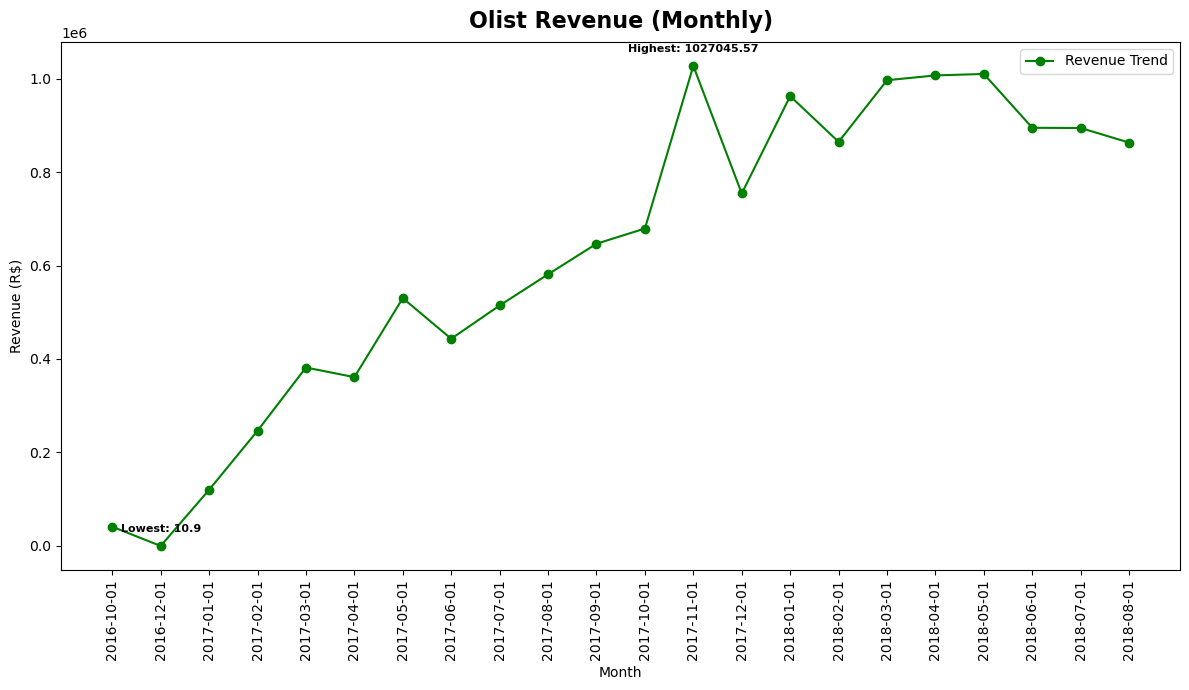

In [756]:
plt.figure(figsize=(12, 7))
monthlyprofit_values = monthly_sales['monthly_revenue'].replace('R$', '').astype(float)
plt.plot(monthly_sales['Year-Month (Purchase)'].astype(str), monthlyprofit_values, marker='o', linestyle='-', color='green',label='Revenue Trend')

# Finding the index of the highest and lowest values
max_index_p = monthlyprofit_values.idxmax()
min_index_p = monthlyprofit_values.idxmin()

# highest and lowest values
plt.annotate(f"Highest: {monthly_sales['monthly_revenue'][max_index_p]}", 
             (monthly_sales['Year-Month (Purchase)'].astype(str)[max_index_p], monthlyprofit_values[max_index_p]),
             textcoords="offset points", xytext=(0,10), ha='center', fontsize=8, fontweight='bold')
plt.annotate(f"Lowest: {monthly_sales['monthly_revenue'][min_index_p]}", 
             (monthly_sales['Year-Month (Purchase)'].astype(str)[min_index_p], monthlyprofit_values[min_index_p]),
             textcoords="offset points", xytext=(0,10), ha='center', fontsize=8, fontweight='bold')

plt.xlabel('Month')
plt.ylabel('Revenue (R$)')
plt.title('Olist Revenue (Monthly)', size=16, pad=10, fontweight='bold')
plt.xticks(rotation=90)
plt.legend()
plt.tight_layout()

plt.show()

In [757]:
print('Multilines Chart of Monthly Sales:')

#Plotly figure with multilines chart
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=monthly_sales['Year-Month (Purchase)'],
    y=monthly_sales['total_orders'],
    mode='lines+markers',
    name='Total Orders'
))

fig.add_trace(go.Scatter(
    x=monthly_sales['Year-Month (Purchase)'],
    y=monthly_sales['total_buyers'],
    mode='lines+markers',
    name='Total Buyers'
))

fig.add_trace(go.Scatter(
    x=monthly_sales['Year-Month (Purchase)'],
    y=monthly_sales['total_sellers'],
    mode='lines+markers',
    name='Total Sellers'
))

fig.update_layout(
    title='Total Orders, Buyers, and Sellers (Monthly)', title_x=0.5,
    xaxis_title='Month',
    yaxis_title='Count',
    legend_title='Metric',
    template='plotly_white'
)

Multilines Chart of Monthly Sales:


## Sellers

In [758]:
# Number of unique seller cities:
state_counts = master_olist_dataset['seller_state'].value_counts().reset_index()
state_counts.columns = ['seller_state', 'count']

fig = px.bar(state_counts, x='seller_state', y='count', 
             title='Number of Sellers by State', 
             labels={'count': 'Number of Sellers'})
fig.show()

In [759]:
# Top 10 cities by number of sellers, coloured by state:
city_state = master_olist_dataset.groupby(['seller_city', 'seller_state'])['seller_id'].nunique().reset_index()
city_state.columns = ['seller_city', 'seller_state', 'seller_count']

top_city_state = city_state.sort_values('seller_count', ascending=False).head(10)

fig = px.bar(top_city_state, x='seller_count', y='seller_city', color='seller_state',
             title='Top 10 Cities by Number of Sellers (Coloured by State)',
             labels={'seller_count': 'Number of Sellers', 'seller_city': 'City'})
fig.update_layout(yaxis={'categoryorder':'total ascending'})
fig.show()

In [760]:
# Total number of items per seller
seller_kpi = master_olist_dataset.groupby('seller_id').agg(
    total_items=('order_id', 'count'),
    unique_orders=('order_id', 'nunique')
).reset_index()

seller_kpi.head()

seller_id              total_items  unique_orders
0  0015a82c2db000af6aaaf3ae2ecb0532        3             3     
1  001cca7ae9ae17fb1caed9dfb1094831      236           195     
2  002100f778ceb8431b7a1020ff7ab48f       57            50     
3  003554e2dce176b5555353e4f3555ac8        1             1     
4  004c9cd9d87a3c30c522c48c4fc07416      202           156

In [761]:
# Count how many unique sellers each order has
items_per_order = master_olist_dataset.groupby('order_id')['seller_id'].nunique().reset_index(name='unique_seller_count')
items_per_order.head()

order_id              unique_seller_count
0  00010242fe8c5a6d1ba2dd792cb16214           1         
1  00018f77f2f0320c557190d7a144bdd3           1         
2  000229ec398224ef6ca0657da4fc703e           1         
3  00024acbcdf0a6daa1e931b038114c75           1         
4  00042b26cf59d7ce69dfabb4e55b4fd9           1

In [762]:
multiple_sellers_orders = items_per_order[items_per_order['unique_seller_count'] > 1]
multiple_sellers_orders = multiple_sellers_orders.sort_values(by='unique_seller_count', ascending=False)
multiple_sellers_orders

order_id              unique_seller_count
10578  1c11d0f4353b31ac3417fbfa5f0f2a8a           5         
10962  1d23106803c48c391366ff224513fb7f           4         
52498  8c2b13adf3f377c8f2b06b04321b0925           4         
96165  ffb8f7de8940249a3221252818937ecb           3         
63533  a98012aa8c697f2bcff9f8c2183e0f2b           3         
...                                 ...                  ...
33438  591083bc42b589c7052118aa83118e76           2         
33382  58e03095584d960583933517a2aae5df           2         
33345  58c4df4904044782bb1361c5cb001538           2         
32836  57638520434d4c12b81d532ad9bf2f1f           2         
48165  804f733828d8587c734a1d8fc5634e06           2         

[1252 rows x 2 columns]

In [763]:

print(multiple_sellers_orders.shape)

(1252, 2)


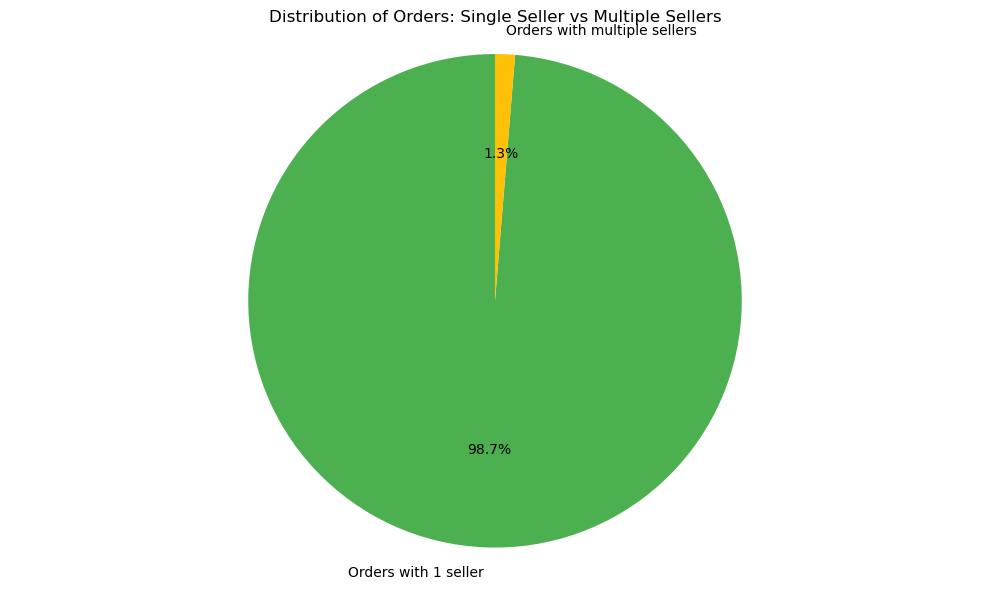

Orders with 1 seller: 95014 (98.70%)
Orders with multiple sellers: 1252 (1.30%)


In [764]:
# Count the number of orders with 1 seller and orders with multiple sellers
single_seller_orders_count = len(items_per_order[items_per_order['unique_seller_count'] == 1])
multiple_seller_orders_count = len(items_per_order[items_per_order['unique_seller_count'] > 1])

# Create labels and values for the pie chart
labels = ['Orders with 1 seller', 'Orders with multiple sellers']
sizes = [single_seller_orders_count, multiple_seller_orders_count]

# Create the pie chart
plt.figure(figsize=(10, 6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=['#4CAF50', '#FFC107'])
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
plt.title('Distribution of Orders: Single Seller vs Multiple Sellers')
plt.tight_layout()
plt.show()

# Print the actual numbers
print(f"Orders with 1 seller: {single_seller_orders_count} ({single_seller_orders_count/len(items_per_order)*100:.2f}%)")
print(f"Orders with multiple sellers: {multiple_seller_orders_count} ({multiple_seller_orders_count/len(items_per_order)*100:.2f}%)")

## Customers

In [765]:
df_customers_geo = master_olist_dataset[['customer_id','customer_unique_id','customer_zip_code_prefix','customer_state','customer_city']].reset_index()


In [766]:
df_customers_state = master_olist_dataset[['customer_unique_id', 'customer_state']].drop_duplicates().reset_index(drop=True)


In [767]:
top_state = df_customers_state['customer_state'].value_counts().nlargest(10).reset_index()
top_state

customer_state  count
0       SP        39080
1       RJ        11898
2       MG        10974
3       RS         5149
4       PR         4756
5       SC         3437
6       BA         3154
7       DF         2015
8       ES         1922
9       GO         1889

In [768]:
# Customer state distribution:
fig = px.histogram(
    df_customers_state,
    x='customer_state',
    title='Number of Customers by State',
    labels={'customer_state': 'State'},
    color='customer_state',                     
    color_discrete_sequence=px.colors.qualitative.Plotly,
      
)

fig.update_layout(
    xaxis_title='State',
    yaxis_title='Number of Customers',
    template='plotly_white'
)   
fig.show()


In [769]:
top_cities = df_customers_geo['customer_city'].value_counts().nlargest(20).reset_index()
top_cities

customer_city       count
0               sao paulo  18205
1          rio de janeiro   7958
2          belo horizonte   3186
3                brasilia   2414
4                curitiba   1783
5                campinas   1711
6            porto alegre   1610
7                salvador   1473
8               guarulhos   1361
9   sao bernardo do campo   1096
10                niteroi   1031
11            santo andre    896
12                 osasco    867
13                 santos    836
14                goiania    830
15    sao jose dos campos    799
16              fortaleza    727
17               sorocaba    714
18                 recife    684
19                jundiai    671

In [770]:
# Customer city distribution (top 20):
top_cities = df_customers_geo['customer_city'].value_counts().nlargest(20).reset_index()
top_cities.columns = ['city', 'count']

fig = px.bar(
    top_cities,
    x='city',
    y='count',
    title='Top 20 Customers Cities',
    color='count',
    color_continuous_scale='Oxy'
)

fig.update_layout(
    xaxis_title='Cities',
    yaxis_title='Count',
    template='plotly_white'
)  
fig.show()

##### Customer behaviours 

In [771]:
#popular products by sales count
popular_products = master_olist_dataset.groupby(['product_id','product_category_name','product_category_name_english']).agg(sales_count=('order_id', 'count'), revenue = ('price','sum')).reset_index()
top10_products_bysales = popular_products.sort_values(by='sales_count', ascending=False).head(10)      
display(top10_products_bysales)

product_id             product_category_name  product_category_name_english  sales_count   revenue
21571  aca2eb7d00ea1a7b8ebd4e68314663af        moveis_decoracao            furniture_decor         529      37743.60
19249  99a4788cb24856965c36a24e339b6058         cama_mesa_banho             bed_bath_table         515      45419.96
8409   422879e10f46682990de24d770e7f83d      ferramentas_jardim               garden_tools         508      27851.62
7188   389d119b48cf3043d311335e499d9c6b      ferramentas_jardim               garden_tools         403      22027.49
6908   368c6c730842d78016ad823897a372db      ferramentas_jardim               garden_tools         398      21601.10
10565  53759a2ecddad2bb87a079a1f1519f73      ferramentas_jardim               garden_tools         391      21390.70
26377  d1c427060a0f73f6b889a5c7c61f2ac4  informatica_acessorios      computers_accessories         345      47437.46
10592  53b36df67ebb7c41585e8d54d6772e08      relogios_presentes              watches_gifts         325      37929.42
2725   154e7e31ebfa092203795c972e5804a6            beleza_saude              health_beauty         280       6309.20
7862   3dd2a17168ec895c781a9191c1e95ad7  informatica_acessorios      computers_accessories         276      41382.40

In [772]:
#popular products by revenue
popular_products = master_olist_dataset.groupby(['product_id','product_category_name','product_category_name_english']).agg(sales_count=('order_id', 'count'), revenue = ('price','sum')).reset_index()
top10_products_byrevenue = popular_products.sort_values(by='revenue', ascending=False).head(10)      
display(top10_products_byrevenue)

product_id             product_category_name  product_category_name_english  sales_count   revenue
23496  bb50f2e236e5eea0100680137654686c            beleza_saude              health_beauty         208      68160.00
13718  6cdd53843498f92890544667809f1595            beleza_saude              health_beauty         156      54702.00
26938  d6160fb7873f184099d9bc95e30376af                     pcs                  computers          39      53998.84
26377  d1c427060a0f73f6b889a5c7c61f2ac4  informatica_acessorios      computers_accessories         345      47437.46
19249  99a4788cb24856965c36a24e339b6058         cama_mesa_banho             bed_bath_table         515      45419.96
4879   25c38557cf793876c5abdd5931f922db                   bebes                       baby          44      44829.32
7862   3dd2a17168ec895c781a9191c1e95ad7  informatica_acessorios      computers_accessories         276      41382.40
10592  53b36df67ebb7c41585e8d54d6772e08      relogios_presentes              watches_gifts         325      37929.42
21571  aca2eb7d00ea1a7b8ebd4e68314663af        moveis_decoracao            furniture_decor         529      37743.60
12047  5f504b3a1c75b73d6151be81eb05bdc9              cool_stuff                 cool_stuff          63      37733.90

In [773]:
#type of payment

df_payment_type = master_olist_dataset.groupby('payment_type')['order_id'].count().reset_index()

total_reviews = df_payment_type['order_id'].sum()
df_payment_type['percentage (%)'] = (df_payment_type['order_id'] / total_reviews * 100).round(2)

display(df_payment_type)

payment_type  order_id  percentage (%)
0       boleto    22398        19.46    
1  credit_card    84901        73.77    
2   debit_card     1652         1.44    
3      voucher     6142         5.34

In [774]:
figsegment = go.Figure(data=[go.Pie(
    labels=df_payment_type['payment_type'],  
    values=df_payment_type['percentage (%)'].values,  
    hole=0.4,
    hoverinfo='label+percent+value',
    textinfo='percent+label'
)])

figsegment.update_traces(textposition='auto')
figsegment.update_layout(
    title_text="Segment Proportion (%)", title_x=0.5,
    showlegend=False
)

figsegment.show()

In [775]:
#repeat customers

orders_per_customer = master_olist_dataset.groupby('customer_unique_id')['order_id'].nunique()
n_repeat_customers = (orders_per_customer > 1).sum()


n_customers = master_olist_dataset['customer_unique_id'].nunique()

repeat_pcg = n_repeat_customers / n_customers
onetime_pcg = 1 - repeat_pcg

display(f'Total Customers: {n_customers}')
display(f'Total Repeat Customers: {n_repeat_customers}')
display(f'Total One-time Customers: {n_customers - n_repeat_customers}')
display(f'Repeat Customers Percentage / Customer retention: {repeat_pcg:.2%}')
display(f'One time Customers Percentage: {onetime_pcg:.2%}')
display(orders_per_customer.describe())

'Total Customers: 93155'

'Total Repeat Customers: 2793'

'Total One-time Customers: 90362'

'Repeat Customers Percentage / Customer retention: 3.00%'

'One time Customers Percentage: 97.00%'

count    93155.000000
mean         1.033396
std          0.209001
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max         15.000000
Name: order_id, dtype: float64

In [776]:
#basket size 

#basket size based on order_item_id
n_item_per_order = master_olist_dataset.groupby('order_item_id')['order_id'].count().reset_index()
total_reviews = n_item_per_order['order_id'].sum()
n_item_per_order['percentage (%)'] = (n_item_per_order['order_id'] / total_reviews * 100).round(3)

# Display the result
display(n_item_per_order)

order_item_id  order_id  percentage (%)
0        1.0        100810       87.590    
1        2.0         10069        8.749    
2        3.0          2332        2.026    
3        4.0           958        0.832    
4        5.0           450        0.391    
5        6.0           255        0.222    
6        7.0            60        0.052    
7        8.0            37        0.032    
8        9.0            29        0.025    
9       10.0            26        0.023    
10      11.0            18        0.016    
11      12.0            13        0.011    
12      13.0             8        0.007    
13      14.0             7        0.006    
14      15.0             5        0.004    
15      16.0             3        0.003    
16      17.0             3        0.003    
17      18.0             3        0.003    
18      19.0             3        0.003    
19      20.0             3        0.003    
20      21.0             1        0.001

In [777]:

fig = px.histogram(master_olist_dataset, x="order_item_id",
             color='order_item_id', barmode='relative',
             histfunc='count', text_auto=True,
             height=1000, width=700,
             labels={
                     "order_item_id": "Order Item ID",
                     })

fig.update_traces(textposition='outside',texttemplate="<b>%{y:.2f}</b>")
fig.update_layout(
    title_text="Number of item per order", title_x=0.5,
    barmode="relative",
    uniformtext=dict(mode="hide", minsize=10),
    xaxis={'categoryorder': 'total ascending'}
)
fig.show()

As an additional analyses, we want to understand about high and low value customers for customer segmentation. **Here, we use RFM - Recency, Frequency and Monetary scoring to identify the high and low value customer that previously bought product from Olist.**

1. Recency: How recently the customer made a purchase
2. Frequency: how often the customer makes purchases
3. Monetary: how much money (total amount) was spent to buy the products

In [778]:
df_custrecency = master_olist_dataset.groupby(by='customer_unique_id', as_index=False)['order_purchase_timestamp'].max()
df_custrecency.columns = ['Customer', 'LastPurchaseDate']
recent_date = df_custrecency['LastPurchaseDate'].max()
df_custrecency['Recency'] = df_custrecency['LastPurchaseDate'].apply(lambda x: (recent_date - x).days)
df_custrecency = df_custrecency.sort_values(by='Recency', ascending=True).reset_index(drop=True)

display(df_custrecency.head(), df_custrecency.tail())

Customer               LastPurchaseDate   Recency
0  fb7e29c65321441231990afc201c1b14 2018-08-28 19:32:05     0   
1  21dbe8eabd00b34492a939c540e2b1a7 2018-08-29 10:22:35     0   
2  24ac2b4327e25baf39f2119e4228976a 2018-08-29 15:00:37     0   
3  77367b6fbb034ca710d4f41aad009151 2018-08-28 21:10:46     0   
4  c45221bb4573f66bdd4daf43fe2d4b3b 2018-08-28 19:27:43     0

Customer               LastPurchaseDate   Recency
93150  87776adb449c551e74c13fc34f036105 2016-10-03 22:31:31    694  
93151  61db744d2f835035a5625b59350c6b63 2016-10-03 21:13:36    694  
93152  88bc832f104b6dd684a17dbb1b76e778 2016-10-04 09:59:03    694  
93153  10e89fd8e5c745f81bec101207ba4d7d 2016-10-03 22:51:30    694  
93154  5f7e36fb1d42d0b1c408b5b41bc52bb3 2016-10-04 13:15:52    694

In [779]:
custfrequency_df = (
    master_olist_dataset[['customer_unique_id', 'order_id']]
    .drop_duplicates()
    .groupby('customer_unique_id', as_index=False)
    .count()
    .rename(columns={'order_id': 'Frequency', 'customer_unique_id': 'Customer'})
    .sort_values(by='Frequency', ascending=False)
    .reset_index(drop=True) 
)

display(custfrequency_df.head(), custfrequency_df.tail())

Customer              Frequency
0  8d50f5eadf50201ccdcedfb9e2ac8455     15    
1  3e43e6105506432c953e165fb2acf44c      9    
2  1b6c7548a2a1f9037c1fd3ddfed95f33      7    
3  6469f99c1f9dfae7733b25662e7f1782      7    
4  ca77025e7201e3b30c44b472ff346268      7

Customer              Frequency
93150  56636fd22de1a315b8a50d45cf94d859      1    
93151  5663350f41f9077e7c27f2ab1131bd13      1    
93152  5662855e2f6ad60ab412adcd3ed030fe      1    
93153  566247c9538d4a0c5739d6f11f73c655      1    
93154  ffffd2657e2aad2907e67c3e9daecbeb      1

In [780]:
monetary_df = master_olist_dataset.groupby(by='customer_unique_id', as_index=False)['price'].sum().sort_values(by='price', ascending=False)
monetary_df.columns = ['Customer', 'Monetary']
display(monetary_df.head(), monetary_df.tail())

Customer              Monetary
3713   0a0a92112bd4c708ca5fde585afaa872  13440.00
71654  c4b224d2c784bae11ae98b6ae9f2454c  10856.10
48613  85963fd37bfd387aa6d915d8a1065486   9888.00
69394  be74c431147c32ab2d7c7cef5e4a995f   9520.14
86699  edf81e1f3070b9dac83ec83dacdbb9bc   7998.00

Customer              Monetary
39888  6d6065917074c293416673faaba09336    3.00  
75448  cf3839da0d9492ad151690b65f45d800    2.99  
68867  bd06ce0e06ad77a7f681f1a4960a3cc6    2.29  
65398  b38211bd797f4fdd81a98b9d1754b606    0.85  
78718  d80730c15c647bc8f2ad77c908ba5ca9    0.85

In [781]:
rf_df = df_custrecency.merge(custfrequency_df, on='Customer')
rfm_df = rf_df.merge(monetary_df, on='Customer').drop(
    columns='LastPurchaseDate')

rfm_df.head(10)

Customer              Recency  Frequency  Monetary
0  fb7e29c65321441231990afc201c1b14     0         2       268.69 
1  21dbe8eabd00b34492a939c540e2b1a7     0         1         6.90 
2  24ac2b4327e25baf39f2119e4228976a     0         1        84.99 
3  77367b6fbb034ca710d4f41aad009151     0         1        59.90 
4  c45221bb4573f66bdd4daf43fe2d4b3b     0         1        29.90 
5  5c58de6fb80e93396e2f35642666b693     0         1       418.00 
6  a712a430955027da5bc257a10073a390     0         1       149.90 
7  83176537f63ef9c7510572006c85ac50     0         1       712.90 
8  36a5c01d940c382346247b3e6c485c2d     0         1        29.99 
9  44d111bdc55faca551ef91cb74a444d8     0         1       249.90

In [782]:
rf_df_2 = custfrequency_df.merge(monetary_df, on='Customer')
rf_df_2.head(10)

Customer              Frequency  Monetary
0  8d50f5eadf50201ccdcedfb9e2ac8455     15        714.63
1  3e43e6105506432c953e165fb2acf44c      9       1000.85
2  1b6c7548a2a1f9037c1fd3ddfed95f33      7        855.21
3  6469f99c1f9dfae7733b25662e7f1782      7        664.20
4  ca77025e7201e3b30c44b472ff346268      7        806.61
5  12f5d6e1cbf93dafd9dcc19095df0b3d      6         58.40
6  63cfc61cee11cbe306bff5857d00bfe4      6        579.81
7  dc813062e0fc23409cd255f7f53c7074      6        687.76
8  47c1a3033b8b77b3ab6e109eb4d5fdf3      6        874.60
9  f0e310a6839dce9de1638e0fe5ab282a      6        438.09

## Review

In [783]:
df_reviews = master_olist_dataset.copy()  # Replace with your full review dataset

In [784]:

fig = px.histogram(df_reviews, x="review_score",
             color='review_score', barmode='relative',
             histfunc='count', text_auto=True,
             height=700, width=700,
             labels={
                     "review_score": "Review Score",
                     },
             category_orders={'Review Score': [1, 2, 3, 4, 5]}
            )

fig.update_traces(textposition='outside',texttemplate="<b>%{y:.1f}</b>")

fig.update_layout(
    title_text="Rating", title_x=0.5,
    barmode="relative",
    uniformtext=dict(mode="hide", minsize=10),
    xaxis={'categoryorder': 'total ascending'}
)
fig.show()

In [785]:
# Make sure comment length and month are already computed:
df_reviews['comment_length'] = df_reviews['review_comment_message'].astype(str).apply(len)
df_reviews['month'] = pd.to_datetime(df_reviews['review_creation_date']).dt.to_period("M").astype(str)

# Count reviews per score per month:
low_score_summary = (
    df_reviews[df_reviews['review_score'].isin([1, 2, 3])]
    .groupby(['month', 'review_score'])
    .agg(count=('review_id', 'count'))
    .reset_index()
)

# Pivot to wide format:
highlight_table = low_score_summary.pivot(index='month', columns='review_score', values='count').fillna(0)

# Add a total low score column:
highlight_table['total_low_reviews'] = highlight_table.sum(axis=1)

# Sort by total_low_reviews:
highlight_table = highlight_table.sort_values(by='total_low_reviews', ascending=False)

In [786]:
# all review scores (1 to 5)
all_score_summary = df_reviews.copy() 
all_score_summary['review_score'] = all_score_summary['review_score'].astype(str)

# Group by month and review_score
all_score_plot_data = (
    all_score_summary
    .groupby(['month', 'review_score'])
    .size()
    .reset_index(name='count')
)

# Plot
fig = px.bar(
    all_score_plot_data,
    x='month',
    y='count',
    color='review_score',
    barmode='stack',
    title='Review Score Distribution by Month (1–5 Stars)',
    color_discrete_sequence=px.colors.qualitative.Bold
)

fig.update_layout(
    xaxis_title='Month',
    yaxis_title='Number of Reviews'
)

fig.show()

In [787]:
# Display the top 10 months with the most low score reviews:
top_low_score_months = highlight_table.head(10)
top_low_score_months

review_score    1.0    2.0    3.0   total_low_reviews
month                                                
2018-03       1825.0  366.0  861.0       3052.0      
2017-12       1394.0  372.0  787.0       2553.0      
2018-04       1280.0  353.0  730.0       2363.0      
2018-08        873.0  301.0  719.0       1893.0      
2018-02        888.0  249.0  669.0       1806.0      
2018-01        869.0  272.0  633.0       1774.0      
2018-05        861.0  246.0  649.0       1756.0      
2018-06        814.0  268.0  654.0       1736.0      
2017-11        572.0  173.0  529.0       1274.0      
2018-07        518.0  160.0  462.0       1140.0

In [788]:
# Review monthly (1-3 stars) ::
highlight_plot_data = low_score_summary.copy()
highlight_plot_data['review_score'] = highlight_plot_data['review_score'].astype(str)

fig = px.bar(
    highlight_plot_data,
    x='month',
    y='count',
    color='review_score',
    barmode='stack',
    title='Low Review Score Distribution by Month (1-3 Stars)',
    color_discrete_sequence=px.colors.qualitative.Bold
)
fig.update_layout(xaxis_title='Month', yaxis_title='Number of Reviews')
fig.show()

## Delivery

#### General delivery performance

In [789]:
# Core delay & flag features
master_olist_dataset['is_late']    = master_olist_dataset['order_delivered_customer_date'] > master_olist_dataset['order_estimated_delivery_date']
master_olist_dataset['late_days']    = (master_olist_dataset['order_delivered_customer_date'] - master_olist_dataset['order_estimated_delivery_date']).dt.days
master_olist_dataset['dispatch_delay'] = (master_olist_dataset['order_delivered_carrier_date'] - master_olist_dataset['shipping_limit_date']).dt.days
master_olist_dataset['is_late_dispatch'] = (master_olist_dataset['dispatch_delay'] > 0)
master_olist_dataset['dispatch_time'] = (master_olist_dataset['order_delivered_carrier_date'] - master_olist_dataset['order_approved_at']).dt.days
master_olist_dataset['transit_time']  = (master_olist_dataset['order_delivered_customer_date']  - master_olist_dataset['order_delivered_carrier_date']).dt.days
master_olist_dataset['delivery_days'] = (master_olist_dataset['order_delivered_customer_date'] - master_olist_dataset['order_purchase_timestamp']).dt.days

# Review bucket
master_olist_dataset['review_bucket'] = master_olist_dataset['review_score'].apply(lambda x: 'Good (4-5)' if x > 3 else 'Bad (1-3)')

In [790]:
master_olist_dataset.head()

order_id                        customer_id            order_status order_purchase_timestamp  order_approved_at  order_delivered_carrier_date order_delivered_customer_date order_estimated_delivery_date         customer_unique_id         customer_zip_code_prefix customer_city customer_state  order_item_id             product_id                        seller_id             shipping_limit_date   price  freight_value product_category_name   product_name_lenght  product_description_lenght  product_photos_qty  product_weight_g  product_length_cm  product_height_cm  product_width_cm  seller_zip_code_prefix   seller_city   seller_state  payment_sequential payment_type  payment_installments  payment_value             review_id              review_score review_comment_title                                                                            review_comment_message                                                                           review_creation_date  \
0  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   delivered    2017-10-02 10:56:33    2017-10-02 11:07:15     2017-10-04 19:55:00           2017-10-10 21:25:13                2017-10-18           7c396fd4830fd04220f754e42b4e5bff             3149             sao paulo        SP             1.0       87285b34884572647811a353c7ac498a  3504c0cb71d7fa48d967e0e4c94d59d9 2017-10-06 11:07:15   29.99       8.72      utilidades_domesticas         40.0                     268.0                    4.0               500.0             19.0                8.0               13.0                 9350.0                   maua      SP               1.0         credit_card           1.0              18.12      a54f0611adc9ed256b57ede6b6eb5114       4.0                    NaN    Não testei o produto ainda, mas ele veio correto e em boas condições. Apenas a caixa que veio bem amassada e danificada, o que ficará chato, pois se trata de um presente.      2017-10-11        
1  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   delivered    2017-10-02 10:56:33    2017-10-02 11:07:15     2017-10-04 19:55:00           2017-10-10 21:25:13                2017-10-18           7c396fd4830fd04220f754e42b4e5bff             3149             sao paulo        SP             1.0       87285b34884572647811a353c7ac498a  3504c0cb71d7fa48d967e0e4c94d59d9 2017-10-06 11:07:15   29.99       8.72      utilidades_domesticas         40.0                     268.0                    4.0               500.0             19.0                8.0               13.0                 9350.0                   maua      SP               3.0             voucher           1.0               2.00      a54f0611adc9ed256b57ede6b6eb5114       4.0                    NaN    Não testei o produto ainda, mas ele veio correto e em boas condições. Apenas a caixa que veio bem amassada e danificada, o que ficará chato, pois se trata de um presente.      2017-10-11        
2  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   delivered    2017-10-02 10:56:33    2017-10-02 11:07:15     2017-10-04 19:55:00           2017-10-10 21:25:13                2017-10-18           7c396fd4830fd04220f754e42b4e5bff             3149             sao paulo        SP             1.0       87285b34884572647811a353c7ac498a  3504c0cb71d7fa48d967e0e4c94d59d9 2017-10-06 11:07:15   29.99       8.72      utilidades_domesticas         40.0                     268.0                    4.0               500.0             19.0                8.0               13.0                 9350.0                   maua      SP               2.0             voucher           1.0              18.59      a54f0611adc9ed256b57ede6b6eb5114       4.0                    NaN    Não testei o produto ainda, mas ele veio correto e em boas condições. Apenas a caixa que veio bem amassada e danificada, o que ficará chato, pois se trata de um presente.      2017-10-11        
3  53cdb2fc8bc7dce0b6741e2150273451  b0830fb4747a6c6d20dea0b8c802d7ef  

In [791]:
#define functions for late
late_delivery = master_olist_dataset[master_olist_dataset['is_late'] == True].count()['order_id']
total_orders = master_olist_dataset.count()['order_id']
late_delivery_rate = (late_delivery / total_orders) * 100
ontime_delivery_rate = 100 - late_delivery_rate

# Create a pie chart
fig_pie_pull = go.Figure(data=[go.Pie(
    labels = ['On-Time Delivery', 'Late Delivery'],
    values = [ontime_delivery_rate, late_delivery_rate],
    pull = [0, 0.3],
    hoverinfo='label+percent+value',
    textinfo='percent+label'
)])

fig_pie_pull.update_traces(textposition='auto')
fig_pie_pull.update_layout(
    title_text=" Delivery Performance (%)", title_x=0.5,
    showlegend=True
)
fig_pie_pull.show()

#print
print(f"Late Deliveries: {late_delivery}")
print(f"Total Orders: {total_orders}")
print(f"Late Delivery Rate: {late_delivery_rate:.2f}%")
print(f"On-time Delivery Rate: {ontime_delivery_rate:.2f}%")

Late Deliveries: 9041
Total Orders: 115093
Late Delivery Rate: 7.86%
On-time Delivery Rate: 92.14%


#this below can be deleted (but later)

In [792]:
# detail analysis in late and ontime delivery based on dispatch and delivery rate 

df_delivery_segmentation = master_olist_dataset.copy()
def delivery_seg(row):
    if row['is_late_dispatch'] and row['is_late']:
        return 'Late Dispatch and Late Delivery'
    elif not row['is_late_dispatch'] and row['is_late']:
        return 'On-Time Dispatch and Late Delivery'
    elif row['is_late_dispatch'] and not row['is_late']:
        return 'Late Dispatch and On-Time Delivery'
    else:
        return 'On-Time Dispatch and On-Time Delivery'


# add column
df_delivery_segmentation['delivery_segmentation'] = df_delivery_segmentation.apply(delivery_seg, axis=1)

# Count and percentage
del_seg_counts = df_delivery_segmentation['delivery_segmentation'].value_counts()
del_seg_percent = (del_seg_counts / del_seg_counts.sum() * 100).round(2)

display(del_seg_counts, del_seg_percent)

delivery_segmentation
On-Time Dispatch and On-Time Delivery    102534
On-Time Dispatch and Late Delivery         7224
Late Dispatch and On-Time Delivery         3518
Late Dispatch and Late Delivery            1817
Name: count, dtype: int64

delivery_segmentation
On-Time Dispatch and On-Time Delivery    89.09
On-Time Dispatch and Late Delivery        6.28
Late Dispatch and On-Time Delivery        3.06
Late Dispatch and Late Delivery           1.58
Name: count, dtype: float64

In [793]:
# Create a pie chart
pull_map = {
    'Late Dispatch and Late Delivery': 0.5,
    'Late Dispatch and On-Time Delivery': 0.1,
    'On-Time Dispatch and Late Delivery': 0.3,
    'On-Time Dispatch and On-Time Delivery': 0
}


fig_pie_pull_seg = go.Figure(data=[go.Pie(
    labels = del_seg_percent.index,
    values = del_seg_percent.values,
    pull = [pull_map.get(seg, 0) for seg in del_seg_percent.index],
    hoverinfo='label+percent+value',
    textinfo='percent+label'
)])

fig_pie_pull_seg.update_traces(textposition='outside')
fig_pie_pull_seg.update_layout(
    title_text=" Delivery Performance Segmentation (%)", title_x=0.5,
    showlegend=True
)
fig_pie_pull_seg.show()

#delineation only at the late part 

In [794]:
# detail analysis in late and ontime delivery based on dispatch and delivery rate 

df_delivery_segmentation = master_olist_dataset.copy()
def delivery_seg(row):
    if row['is_late_dispatch'] and row['is_late']:
        return 'Late Dispatch and Late Delivery'
    elif not row['is_late_dispatch'] and row['is_late']:
        return 'On-Time Dispatch and Late Delivery'
    else:
        return 'On-Time Delivery'


# add column
df_delivery_segmentation['delivery_segmentation'] = df_delivery_segmentation.apply(delivery_seg, axis=1)

# Count and percentage
del_seg_counts = df_delivery_segmentation['delivery_segmentation'].value_counts()
del_seg_percent = (del_seg_counts / del_seg_counts.sum() * 100).round(2)

display(del_seg_counts, del_seg_percent)

delivery_segmentation
On-Time Delivery                      106052
On-Time Dispatch and Late Delivery      7224
Late Dispatch and Late Delivery         1817
Name: count, dtype: int64

delivery_segmentation
On-Time Delivery                      92.14
On-Time Dispatch and Late Delivery     6.28
Late Dispatch and Late Delivery        1.58
Name: count, dtype: float64

In [795]:
# Create a pie chart
pull_map = {
    'On-Time Delivery': 0,
    'Late Dispatch and Late Delivery': 0.2,
    'On-Time Dispatch and Late Delivery': 0.4
}


fig_pie_pull_seg = go.Figure(data=[go.Pie(
    labels = del_seg_percent.index,
    values = del_seg_percent.values,
    pull = [pull_map.get(seg, 0) for seg in del_seg_percent.index],
    hoverinfo='label+percent+value',
    textinfo='percent+label'
)])

fig_pie_pull_seg.update_traces(textposition='outside')
fig_pie_pull_seg.update_layout(
    title_text=" Delivery Performance Segmentation (%)", title_x=0.5,
    showlegend=True
)
fig_pie_pull_seg.show()

#### Relationship between delivery days and reviews

In [796]:
df_deli_review = master_olist_dataset.groupby('review_score')['delivery_days'].median().reset_index()
df_deli_review

review_score  delivery_days
0       1.0          14.0     
1       2.0          12.0     
2       3.0          11.0     
3       4.0          10.0     
4       5.0           9.0

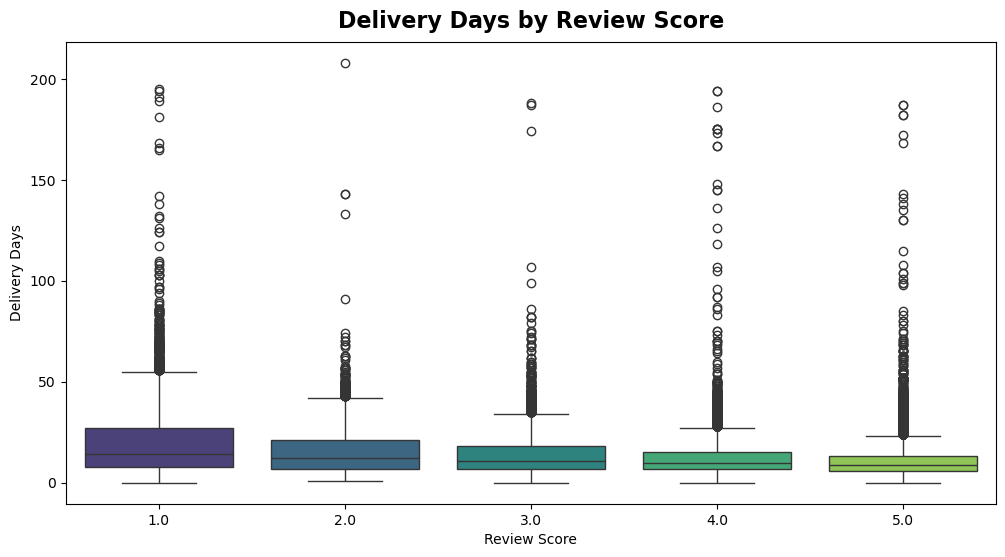

In [797]:
plt.figure(figsize=(12,6))
sns.boxplot(x=df_delivery_segmentation['review_score'], y=df_delivery_segmentation['delivery_days'], palette='viridis')
plt.xlabel('Review Score')
plt.ylabel('Delivery Days')
plt.title('Delivery Days by Review Score', size=16, pad=10, fontweight='bold')
plt.show()

review_score   is_late  late_days  dispatch_delay  dispatch_time  transit_time  delivery_days
review_score      1.000000   -0.274697 -0.152546     -0.067458      -0.104365      -0.178560     -0.220983   
is_late          -0.274697    1.000000  0.466419      0.153993       0.136034       0.340957      0.391011   
late_days        -0.152546    0.466419  1.000000      0.306719       0.174841       0.228807      0.310725   
dispatch_delay   -0.067458    0.153993  0.306719      1.000000       0.590841      -0.042452      0.181418   
dispatch_time    -0.104365    0.136034  0.174841      0.590841       1.000000       0.038517      0.387714   
transit_time     -0.178560    0.340957  0.228807     -0.042452       0.038517       1.000000      0.880884   
delivery_days    -0.220983    0.391011  0.310725      0.181418       0.387714       0.880884      1.000000

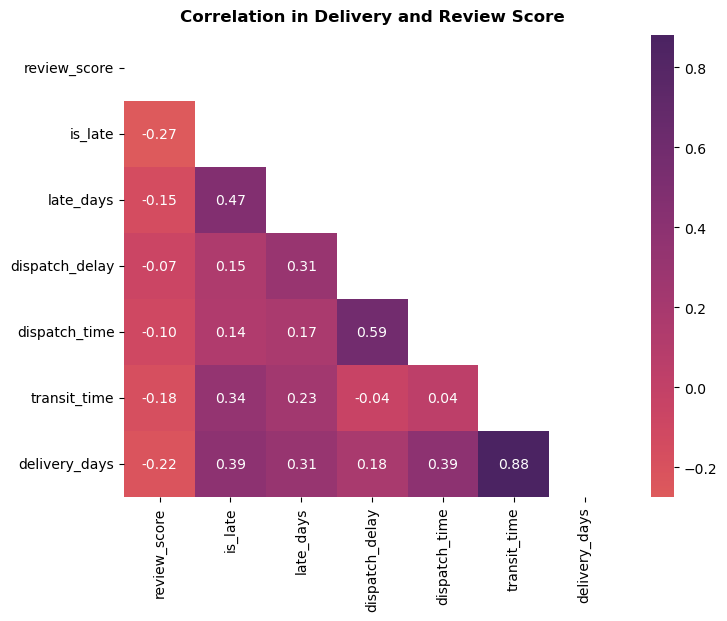

In [798]:
#correlation between numerical variables
correlation_delivery = master_olist_dataset[['review_score','is_late','late_days','dispatch_delay','dispatch_time','transit_time','delivery_days']].corr(method = "spearman")
mtrx = np.triu(correlation_delivery)
display(correlation_delivery)

plt.figure(figsize = (8, 6))
sns.heatmap(
    data = correlation_delivery,
    annot = True,
    fmt = ".2f",
    cmap = "flare",
    center = 0,
    mask = mtrx
)

plt.title("Correlation in Delivery and Review Score", size=12, pad=10, fontweight='bold')
plt.show()

In [799]:
#review bucket 
master_olist_dataset['review_bucket'] = master_olist_dataset['review_score'].apply(lambda x: 'Good (4-5)' if x > 3 else 'Bad (1-3)')

# Create contingency table
cont_table = pd.crosstab(master_olist_dataset['is_late'], master_olist_dataset['review_bucket'])

# chi-square test
chi_square, p_value, dof, expected = chi2_contingency(cont_table)

# print
print("Chi-square statistic:", chi_square)
print("p-value:", p_value)

# Interpret
if p_value < 0.05:
    print("✅ Statistically significant: Late delivery affects review score.")
else:
    print("❌ Not significant: No strong evidence that late delivery affects review score.")

Chi-square statistic: 9783.668378106478
p-value: 0.0
✅ Statistically significant: Late delivery affects review score.


#### How late delivery affecting customer retention - for first timer order

In [800]:
# Customer repeat & first-order flags
master_olist_dataset = master_olist_dataset.sort_values(['customer_unique_id','order_purchase_timestamp'])
master_olist_dataset['order_rank']        = master_olist_dataset.groupby('customer_unique_id')['order_purchase_timestamp'] \
                              .rank(method='first')
master_olist_dataset['first_order_flag']  = master_olist_dataset['order_rank'] == 1

order_counts = master_olist_dataset.groupby('customer_unique_id')['order_id'].nunique()
master_olist_dataset['customer_repeat_flag'] = master_olist_dataset['customer_unique_id'].map(order_counts > 1)

master_olist_dataset.head()

order_id                        customer_id            order_status order_purchase_timestamp  order_approved_at  order_delivered_carrier_date order_delivered_customer_date order_estimated_delivery_date         customer_unique_id         customer_zip_code_prefix customer_city customer_state  order_item_id             product_id                        seller_id             shipping_limit_date   price  freight_value product_category_name  product_name_lenght  product_description_lenght  product_photos_qty  product_weight_g  product_length_cm  product_height_cm  product_width_cm  seller_zip_code_prefix      seller_city      seller_state  payment_sequential payment_type  payment_installments  payment_value             review_id              review_score review_comment_title                                              review_comment_message                                              review_creation_date review_answer_timestamp  has_review  \
61019   e22acc9c116caa3f2b7121bbb380d08e  fadbb3709178fc513abc1b2670aa1ad2   delivered    2018-05-10 10:56:27    2018-05-10 11:11:18     2018-05-12 08:18:00           2018-05-16 20:48:37                2018-05-21           0000366f3b9a7992bf8c76cfdf3221e2             7787              cajamar         SP             1.0       372645c7439f9661fbbacfd129aa92ec  da8622b14eb17ae2831f4ac5b9dab84a 2018-05-15 11:11:18  129.90      12.00         cama_mesa_banho           60.0                     236.0                    1.0              1500.0             34.0                7.0               32.0                13405.0                   piracicaba      SP               1.0         credit_card           8.0             141.90      13359f48c3c7e41a2b8afca340937eeb       5.0        Super Recomendo    Adorei a cortina, ficou linda na minha sala, e o tecido é lindo deixa a sala muito sofisticada. super recomendo      2018-05-17        2018-05-21 13:44:48       True      
85359   3594e05a005ac4d06a72673270ef9ec9  4cb282e167ae9234755102258dd52ee8   delivered    2018-05-07 11:11:27    2018-05-07 18:25:44     2018-05-09 12:18:00           2018-05-10 18:02:42                2018-05-15           0000b849f77a49e4a4ce2b2a4ca5be3f             6053               osasco         SP             1.0       5099f7000472b634fea8304448d20825  138dbe45fc62f1e244378131a6801526 2018-05-11 17:56:33   18.90       8.29            beleza_saude           56.0                     635.0                    1.0               375.0             26.0               11.0               18.0                 2215.0                    sao paulo      SP               1.0         credit_card           1.0              27.19      e383e10e36a765f04f752a37c1674e43       4.0                    NaN                                                                                                                NaN      2018-05-11        2018-05-11 22:29:25       True      
30624   b33ec3b699337181488304f362a6b734  9b3932a6253894a02c1df9d19004239f   delivered    2017-03-10 21:05:03    2017-03-10 21:05:03     2017-03-13 12:58:30           2017-04-05 14:38:47                2017-04-07           0000f46a3911fa3c0805444483337064            88115             sao jose         SC             1.0       64b488de448a5324c4134ea39c28a34b  3d871de0142ce09b7081e2b9d1733cb1 2017-03-15 21:05:03   69.00      17.22               papelaria           49.0                     177.0                    3.0              1500.0             25.0               50.0               35.0                13232.0         campo limpo paulista      SP               1.0         credit_card           8.0              86.22      d89cb4217c23008b141e66c3160de8a4       3.0                    NaN                                                                                                                NaN      2017-04-06        2017-04-07 01:19:44       True      
113968  41272756ecddd9a9ed0180413cc22fb6  914991f0c02ef0843c0e7010c819d642   delivered    2017-10-12 20:29:41    2017-10-12 20:4

In [801]:
# Retention delta (Δ repeat-rate between on-time vs. late first orders)
firsts = master_olist_dataset[master_olist_dataset['first_order_flag']]
ret = firsts.groupby('is_late').agg(
    total_customers=('customer_unique_id','nunique'),
    repeat_customers=('customer_repeat_flag', 'sum')
).reset_index()
ret['repeat_rate'] = ret['repeat_customers']/ret['total_customers']

rr_on_time = ret.loc[ret['is_late']==False, 'repeat_rate'].iloc[0]
rr_late    = ret.loc[ret['is_late']==True,  'repeat_rate'].iloc[0]
retention_delta = rr_on_time - rr_late

print(f"Retention on time first orders: {rr_on_time*100:.4f}%")
print(f"Retention late first orders: {rr_late*100:.4f}%")
print(f"Retention Δ (on-time vs late first orders): {retention_delta*100:.4f}%")

Retention on time first orders: 3.0413%
Retention late first orders: 2.5132%
Retention Δ (on-time vs late first orders): 0.5282%


In [802]:
#Impact model: lost revenue from late first orders
late_first_count = ret.loc[ret['is_late']==True, 'total_customers'].iloc[0]
avg_order_value  = master_olist_dataset['payment_value'].mean()
lost_revenue     = retention_delta * late_first_count * avg_order_value

print(f"Estimated lost revenue from late first orders: {lost_revenue:,.2f}")

Estimated lost revenue from late first orders: 6,901.66


In [803]:
#chisuare analysis 
#  contingency table
cont_table = pd.crosstab(
    firsts['is_late'],
    firsts['customer_repeat_flag']
)

# rename rows/cols for readability
cont_table.index = ['On-Time First Order', 'Late First Order']
cont_table.columns = ['Not Repeated', 'Repeated']

# Chi-Square test
chi2, p, dof, expected = chi2_contingency(cont_table)

# Print
print("Contingency Table:\n", cont_table)
print(f"\nChi² Statistic: {chi2:.4f}")
print(f"Degrees of Freedom: {dof}")
print(f"P-value: {p:.6f}")

if p < 0.05:
    print("\n✅ Statistically significant: Late delivery is associated with customer retention.")
else:
    print("\n❌ Not statistically significant: No clear evidence that late delivery affects retention.")

Contingency Table:
                      Not Repeated  Repeated
On-Time First Order      82953       2602  
Late First Order          7409        191  

Chi² Statistic: 6.5145
Degrees of Freedom: 1
P-value: 0.010700

✅ Statistically significant: Late delivery is associated with customer retention.


### In-dept analysis of delivery performance 

##### On-time Delivery Rate of Olist e-commerce 

In [804]:
# Monthly OTD rate calculation:
df_delivery_segmentation['delivery_month'] = df_delivery_segmentation['order_delivered_customer_date'].dt.to_period('M')
df_delivery_segmentation['delivered_on_time'] = df_delivery_segmentation['is_late'] == False


monthly_otd = (
    df_delivery_segmentation.groupby('delivery_month').agg(
        total_orders=('order_id', 'count'),
        late_orders=('is_late', 'sum'),
        on_time_orders=('delivered_on_time', 'sum')
    ).reset_index()
)

#Calculate OTD rate
monthly_otd['OTD (%)'] = (monthly_otd['on_time_orders'] / monthly_otd['total_orders']) * 100
monthly_otd['OTD (%)'] = monthly_otd['OTD (%)'].round(2)

# Present and print
monthly_otd = monthly_otd.rename(columns={
    'delivery_month': 'Month',
    'total_orders': 'Total Orders',
    'late_orders': 'Late Orders',
    'on_time_orders': 'On-Time Orders'
})



monthly_otd


Month    Total Orders  Late Orders  On-Time Orders  OTD (%)
0   2016-10       245            0            245       100.00 
1   2016-11        80            1             79        98.75 
2   2016-12         4            2              2        50.00 
3   2017-01       342            0            342       100.00 
4   2017-02      1647            3           1644        99.82 
5   2017-03      2912           71           2841        97.56 
6   2017-04      2177          131           2046        93.98 
7   2017-05      4478          254           4224        94.33 
8   2017-06      3872          138           3734        96.44 
9   2017-07      4158          154           4004        96.30 
10  2017-08      5226          134           5092        97.44 
11  2017-09      4743          202           4541        95.74 
12  2017-10      5519          270           5249        95.11 
13  2017-11      5681          275           5406        95.16 
14  2017-12      8659          898           7761        89.63 
15  2018-01      7734          770           6964        90.04 
16  2018-02      6933          435           6498        93.73 
17  2018-03      8277         1279           6998        84.55 
18  2018-04      9306         1651           7655        82.26 
19  2018-05      8442          522           7920        93.82 
20  2018-06      8196          674           7522        91.78 
21  2018-07      6774          115           6659        98.30 
22  2018-08      9626         1000           8626        89.61 
23  2018-09        59           59              0         0.00 
24  2018-10         3            3              0         0.00

In [805]:
# Filter for deliveries completed before 2018:
df_pre_2018 = df_delivery_segmentation[
    df_delivery_segmentation['order_delivered_customer_date'].dt.year < 2018
].copy()

# Calculate total and on-time deliveries:
total_deliveries_pre_2018 = len(df_pre_2018)
on_time_deliveries_pre_2018 = df_pre_2018['delivered_on_time'].sum()

# Calculate OTD:
otd_pre_2018 = (on_time_deliveries_pre_2018 / total_deliveries_pre_2018) * 100
print(f"OTD Rate for 2016-2017: {otd_pre_2018:.2f}%")

# Also display the count for context
print(f"Total deliveries in 2016-2017: {total_deliveries_pre_2018}")
print(f"On-time deliveries in 2016-2017: {on_time_deliveries_pre_2018}")

OTD Rate for 2016-2017: 94.91%
Total deliveries in 2016-2017: 49743
On-time deliveries in 2016-2017: 47210


In [806]:
# Filter for deliveries completed in 2018:
df_2018 = df_delivery_segmentation[
    df_delivery_segmentation['order_delivered_customer_date'].dt.year == 2018
].copy()

# Calculate total and on-time deliveries:
total_deliveries_2018 = len(df_2018)
on_time_deliveries_2018 = df_2018['delivered_on_time'].sum()

# Calculate OTD:
otd_2018 = (on_time_deliveries_2018 / total_deliveries_2018) * 100
print(f"OTD Rate for 2018: {otd_2018:.2f}%")
print(f"Total deliveries in 2018: {total_deliveries_2018}")
print(f"On-time deliveries in 2018: {on_time_deliveries_2018}")

OTD Rate for 2018: 90.04%
Total deliveries in 2018: 65350
On-time deliveries in 2018: 58842


In [807]:

monthly_otd['Month'] = monthly_otd['Month'].astype(str)

# Filter out months with 0% OTD --> no sales 
monthly_otd_filtered = monthly_otd[~monthly_otd['Month'].isin(['2018-09', '2018-10'])].copy()
monthly_otd_filtered = monthly_otd_filtered.sort_values('Month').reset_index(drop=True)

#Prepare y values
y_vals = monthly_otd_filtered['OTD (%)'].values

# Plotly line chart
fig = go.Figure()

# Main OTD line:
fig.add_trace(go.Scatter(
    x=monthly_otd_filtered['Month'],
    y=y_vals,
    mode='lines+markers',
    name='OTD',
    line=dict(color='blue', width=3),
    marker=dict(color='blue', size=8)
))

# Highlight points below 95%:
below_95 = monthly_otd_filtered[monthly_otd_filtered['OTD (%)'] < 95]

fig.add_trace(go.Scatter(
    x=below_95['Month'],
    y=below_95['OTD (%)'],
    mode='markers+text',
    name='Below 95%',
    marker=dict(color='red', size=10, symbol='circle-open'),
    text=['⚠️' for _ in range(len(below_95))],
    textposition='top center',
    showlegend=True
))

fig.update_layout(
    title='Monthly On-Time Delivery (OTD) Trend (Excl. Sep-Oct 2018)',
    xaxis_title='Month',
    yaxis_title='OTD (%)',
    yaxis_range=[75, 101],
    template='plotly_white'
)

fig.show()

#### Total order impacts on OTD rate

In [808]:
# combining two factors OTD and the total orders per month 
# left y axis is OTD rate
fig.add_trace(go.Scatter(
    x=monthly_otd_filtered['Month'],
    y=monthly_otd_filtered['OTD (%)'],
    mode='lines+markers',
    name='OTD (%)',
    line=dict(color='blue', width=3),
    marker=dict(color='blue', size=8),
    yaxis='y1',
    legendgroup= 'otd',
    showlegend=True
))

# right Y axis is the total month order 
fig.add_trace(go.Scatter(
    x=monthly_otd_filtered['Month'],
    y=monthly_otd_filtered['Total Orders'],
    mode='lines+markers',
    name='Total Orders',
    line=dict(color='orange', width=3, dash='dot'),
    marker=dict(color='orange', size=8),
    yaxis='y2'
))

# Highlight OTD below 95% --> for the left axis 
below_95 = monthly_otd_filtered[monthly_otd_filtered['OTD (%)'] < 95]

fig.add_trace(go.Scatter(
    x=below_95['Month'],
    y=below_95['OTD (%)'],
    mode='markers+text',
    name='OTD <95%',
    marker=dict(color='red', size=10, symbol='circle-open'),
    text=['⚠️' for _ in range(len(below_95))],
    textposition='top center',
    showlegend=False,
    yaxis='y1'
))

# layout for two y axes 
fig.update_layout(
    title='Monthly On-Time Delivery Rate vs. Total Orders',
    xaxis=dict(title='Month'),
    yaxis=dict(
        title='OTD (%)',
        range=[75, 101],
        titlefont=dict(color='blue'),
        tickfont=dict(color='blue')
    ),
    yaxis2=dict(
        title='Total Orders',
        overlaying='y',
        side='right',
        titlefont=dict(color='orange'),
        tickfont=dict(color='orange')
    ),
    legend=dict(x=1.05, y=1, bordercolor="gray", borderwidth=1),
    template='plotly_white',
    margin=dict(r=200) 
)

fig.show()

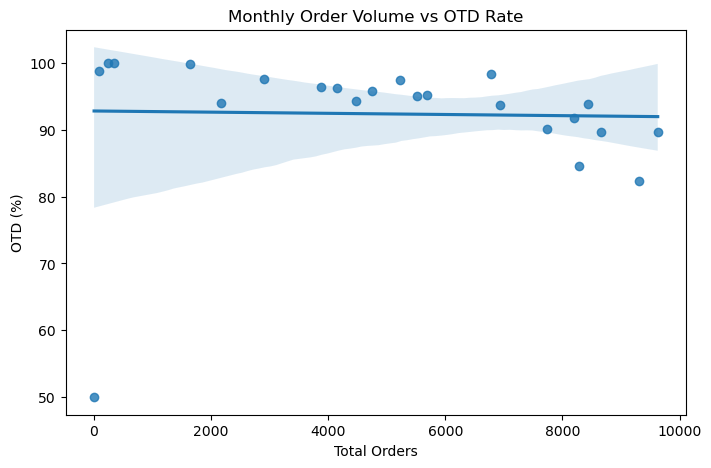

Spearman correlation: -0.627 (p=0.0014)


In [818]:
#correlation between total orders and OTD rate
# 1. Scatterplot
plt.figure(figsize=(8, 5))
sns.regplot(x='Total Orders', y='OTD (%)', data=monthly_otd_filtered)
plt.title('Monthly Order Volume vs OTD Rate')
plt.xlabel('Total Orders')
plt.ylabel('OTD (%)')
plt.show()

# 2. Correlation tests
OTD_order_corr, spearman_p_value = spearmanr(monthly_otd_filtered['Total Orders'], monthly_otd_filtered['OTD (%)'])
print(f"Spearman correlation: {OTD_order_corr:.3f} (p={spearman_p_value:.4f})")


#### Seller delivery performance 

In [810]:
#top 10 order id late 
late_seller_both = master_olist_dataset[
    (master_olist_dataset['is_late'] == True) &
    (master_olist_dataset['is_late_dispatch'] == True)
]

late_seller_dispatch = master_olist_dataset[
    (master_olist_dataset['is_late_dispatch'] == True)
]


In [811]:
top10_late_seller = late_seller_both.groupby('seller_id')['order_id'].nunique().reset_index().sort_values(by='order_id', ascending=False).head(10)
top10_late_seller

seller_id              order_id
16   06a2c3af7b3aee5d69171b0e14f0ee87     77   
31   1025f0e2d44d7041d6cf58b6550e0bfa     42   
281  88460e8ebdecbfecb5f9601833981930     40   
263  8160255418d5aaa7dbdc9f4c64ebda44     30   
250  7c67e1448b00f6e969d365cea6b010ab     27   
164  54965bbe3e4f07ae045b90b0b8541f52     22   
341  a49928bcdf77c55c6d6e05e09a9b4ca5     21   
98   2eb70248d66e0e3ef83659f71b244378     19   
246  7aa4334be125fcdd2ba64b3180029f14     17   
468  e9bc59e7b60fc3063eb2290deda4cced     16

In [812]:
top10_late_seller_dispatch = late_seller_dispatch.groupby('seller_id')['order_id'].nunique().reset_index().sort_values(by='order_id', ascending=False).head(10)
top10_late_seller_dispatch

seller_id              order_id
455  7c67e1448b00f6e969d365cea6b010ab     140  
507  88460e8ebdecbfecb5f9601833981930      98  
29   06a2c3af7b3aee5d69171b0e14f0ee87      97  
58   1025f0e2d44d7041d6cf58b6550e0bfa      82  
475  8160255418d5aaa7dbdc9f4c64ebda44      67  
445  7aa4334be125fcdd2ba64b3180029f14      50  
171  2eb70248d66e0e3ef83659f71b244378      49  
497  85d9eb9ddc5d00ca9336a2219c97bb13      48  
195  37515688008a7a40ac93e3b2e4ab203f      45  
261  4a3ca9315b744ce9f8e9374361493884      42

In [813]:
n_seller_late_both = late_seller_both['seller_id'].nunique()
n_seller_late_dispatch = late_seller_dispatch['seller_id'].nunique()   
n_total_sellers = master_olist_dataset['seller_id'].nunique() 
ratio_late_both = n_seller_late_both / n_total_sellers * 100
ratio_late_dispatch = n_seller_late_dispatch / n_total_sellers * 100

print(f"Total number of sellers: {n_total_sellers}")
print(f"Number of sellers with late dispatch and delivery: {n_seller_late_both}")
print(f"Number of sellers with late dispatch only: {n_seller_late_dispatch}")
print(f"Percentage of sellers with late dispatch and delivery: {ratio_late_both:.2f}%")
print(f"Percentage of sellers with late dispatch only: {ratio_late_dispatch:.2f}%")

Total number of sellers: 2965
Number of sellers with late dispatch and delivery: 518
Number of sellers with late dispatch only: 944
Percentage of sellers with late dispatch and delivery: 17.47%
Percentage of sellers with late dispatch only: 31.84%


In [814]:
#product category analysis related to late delivery

late_products = master_olist_dataset[master_olist_dataset['is_late'] == True]   
late_products_count = late_products.groupby('product_category_name_english')['order_id'].nunique().reset_index()
late_products_count.columns = ['product_category_name_english', 'late_order_count']
late_products_count = late_products_count.sort_values(by='late_order_count', ascending=False).head
late_products_count(10)

product_category_name_english  late_order_count
7              bed_bath_table            811      
41              health_beauty            774      
62             sports_leisure            584      
37            furniture_decor            535      
14      computers_accessories            503      
68              watches_gifts            468      
47                 housewares            399      
65                  telephony            349      
5                        auto            327      
66                       toys            286

In [815]:
# Core delay & flag features
master_olist_dataset['is_late']    = master_olist_dataset['order_delivered_customer_date'] > master_olist_dataset['order_estimated_delivery_date']
master_olist_dataset['late_days']    = (master_olist_dataset['order_delivered_customer_date'] - master_olist_dataset['order_estimated_delivery_date']).dt.days
master_olist_dataset['dispatch_delay'] = (master_olist_dataset['order_delivered_carrier_date'] - master_olist_dataset['shipping_limit_date']).dt.days
master_olist_dataset['is_late_dispatch'] = (master_olist_dataset['dispatch_delay'] > 0)
master_olist_dataset['dispatch_time'] = (master_olist_dataset['order_delivered_carrier_date'] - master_olist_dataset['order_approved_at']).dt.days
master_olist_dataset['transit_time']  = (master_olist_dataset['order_delivered_customer_date']  - master_olist_dataset['order_delivered_carrier_date']).dt.days
master_olist_dataset['delivery_days'] = (master_olist_dataset['order_delivered_customer_date'] - master_olist_dataset['order_purchase_timestamp']).dt.days

# Review bucket
master_olist_dataset['review_bucket'] = master_olist_dataset['review_score'].apply(lambda x: 'Good (4-5)' if x > 3 else 'Bad (1-3)')